In [1]:
# Importing required libraries and setting the directory path

import os
import pandas as pd
import numpy as np
import time
import matplotlib.pyplot as plt
import pickle
import datetime
from sklearn.model_selection import train_test_split
import xgboost as xgb
from xgboost import XGBRegressor
from sklearn.multioutput import MultiOutputRegressor
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import GridSearchCV

%matplotlib inline

july = os.path.join(os.getcwd(), 'datasets/bitbrains/rnd/2013-7/')
august = os.path.join(os.getcwd(), 'datasets/bitbrains/rnd/2013-8/')
septempber = os.path.join(os.getcwd(), 'datasets/bitbrains/rnd/2013-9/')

In [31]:
def df_processing(df):

    df.columns = df.columns.str.replace('\t', '')

    df.insert(0, "DateTime", df['Timestamp [ms]'].apply(lambda x: datetime.datetime.fromtimestamp(x).replace(second=0, microsecond=0)))
    df = df.drop(columns=['Timestamp [ms]'])
    df.set_index('DateTime', inplace=True)
    df = df.sort_index()
    df = df.resample('5min').ffill()
    return df

df2_july = pd.read_csv(os.path.join(july, '383.csv'), sep=';')
# df2_aug = pd.read_csv(os.path.join(august, '383.csv'), sep=';')
# df2_sep = pd.read_csv(os.path.join(septempber, '383.csv'), sep=';')

# df4_july = pd.read_csv(os.path.join(july, '392.csv'), sep=';')
# df4_aug = pd.read_csv(os.path.join(august, '392.csv'), sep=';')
# df4_sep = pd.read_csv(os.path.join(septempber, '392.csv'), sep=';')

# df6_july = pd.read_csv(os.path.join(july, '386.csv'), sep=';')
# df6_aug = pd.read_csv(os.path.join(august, '386.csv'), sep=';')
# df6_sep = pd.read_csv(os.path.join(septempber, '386.csv'), sep=';')

# dfs2_list = [df2_july, df2_aug, df2_sep]
# dfs4_list = [df4_july, df4_aug, df4_sep]
# dfs6_list = [df6_july, df6_aug, df6_sep]

# dfs2 = [df_processing(df) for df in dfs2_list]
# dfs4 = [df_processing(df) for df in dfs4_list]
# dfs6 = [df_processing(df) for df in dfs6_list]

# df2 = pd.concat(dfs2)
# df2 = df2.bfill()
# df4 = pd.concat(dfs4)
# df4 = df4.bfill()
# df6 = pd.concat(dfs6)
# df6 = df6.bfill()


In [35]:
df2_july.head(20)

,Timestamp [ms],\tCPU cores,\tCPU capacity provisioned [MHZ],\tCPU usage [MHZ],\tCPU usage [%],\tMemory capacity provisioned [KB],\tMemory usage [KB],\tDisk read throughput [KB/s],\tDisk write throughput [KB/s],\tNetwork received throughput [KB/s],\tNetwork transmitted throughput [KB/s]
0,1372629804,2,5851.998944,1234.771777,21.100000,4177920.0,1.442838e+06,2640.266667,349.800000,14.066667,13.066667
1,1372630104,2,5851.998944,1117.731798,19.100000,4177920.0,1.635777e+06,2492.200000,423.533333,84.800000,5.600000
2,1372630404,2,5851.998944,1207.462449,20.633333,4177920.0,1.426061e+06,2840.466667,158.666667,11.466667,1.666667
3,1372630704,2,5851.998944,1082.619805,18.500000,4177920.0,1.199570e+06,165.800000,279.066667,25.600000,14.000000
4,1372631004,2,5851.998944,1125.534464,19.233333,4177920.0,1.023408e+06,74.200000,120.800000,0.266667,1.000000
5,1372631304,2,5851.998944,1117.731798,19.100000,4177920.0,1.001038e+06,2689.466667,101.866667,0.400000,0.800000
6,1372631604,2,5851.998944,1107.978467,18.933333,4177920.0,2.164260e+06,82.400000,87.866667,0.133333,0.533333
7,1372631904,2,5851.998944,1109.929133,18.966667,4177920.0,1.166015e+06,2841.066667,110.466667,0.533333,1.200000
8,1372632204,2,5851.998944,1139.189128,19.466667,4177920.0,1.291844e+06,120.533333,102.000000,0.400000,7.133333
9,1372632504,2,5851.998944,1010.445151,17.266667,4177920.0,1.124072e+06,60.600000,92.666667,0.133333,0.533333


In [3]:
def fill_missing(df, start, end):
    df.reset_index(inplace=True)

    # Identify the previous day's period for replication
    previous_day_start = start - pd.DateOffset(days=1)
    previous_day_end = end - pd.DateOffset(days=1)

    # Filter the DataFrame to get the previous day's data
    previous_day_data = df[(df['DateTime'] >= previous_day_start) & (df['DateTime'] <= previous_day_end)]

    # Generate new timestamps for the missing period
    missing_period_timestamps = pd.date_range(start=start, end=end, freq='5min')

    # Replicate the previous day's data to the missing period
    replicated_data = previous_day_data.copy()
    replicated_data['DateTime'] = missing_period_timestamps[:len(previous_day_data)]

    # Concatenate the replicated data with the original DataFrame
    df_filled = pd.concat([df, replicated_data]).sort_values(by='DateTime').reset_index(drop=True)
    df_filled.set_index('DateTime', inplace=True)

    return df_filled

start_july = pd.to_datetime('2013-07-30 23:00:00')
end_july = pd.to_datetime('2013-07-31 23:00:00')
start_aug = pd.to_datetime('2013-08-30 23:00:00')
end_aug = pd.to_datetime('2013-08-31 23:00:00')
df2 = fill_missing(df2, start_july, end_july)
df2 = fill_missing(df2, start_aug, end_aug)
df4 = fill_missing(df4, start_july, end_july)
df4 = fill_missing(df4, start_aug, end_aug)
df6 = fill_missing(df6, start_july, end_july)
df6 = fill_missing(df6, start_aug, end_aug)

#df_list = [df2, df4, df6]
#merged_df = pd.concat(df_list)

In [4]:
#merged_df = merged_df.sort_index()
#df = merged_df
def df_final_processing(df): 
    df = df[['CPU usage [%]']]
    df = df[df.index > '2013-06-30 23:55:00']
    df.sort_index(inplace=True)
    df.reset_index(inplace=True)
    #df.sort_values(by=['DateTime', 'CPU cores'], inplace=True)
    df.rename(columns={"CPU cores": "unique_id", "DateTime": "ds", "CPU usage [%]": "y"}, inplace=True)

    return df

df2 = df_final_processing(df2)
df4 = df_final_processing(df4)
df6 = df_final_processing(df6)
df2.head(12)

,ds,y
0,2013-07-01 00:00:00,17.300000
1,2013-07-01 00:05:00,20.600000
2,2013-07-01 00:10:00,17.566667
3,2013-07-01 00:15:00,18.233333
4,2013-07-01 00:20:00,17.366667
5,2013-07-01 00:25:00,17.866667
6,2013-07-01 00:30:00,17.633333
7,2013-07-01 00:35:00,18.533333
8,2013-07-01 00:40:00,17.900000
9,2013-07-01 00:45:00,19.100000


In [5]:
df6.tail()

,ds,y
26191,2013-09-29 22:35:00,33.933333
26192,2013-09-29 22:40:00,44.500000
26193,2013-09-29 22:45:00,31.300000
26194,2013-09-29 22:50:00,42.000000
26195,2013-09-29 22:55:00,33.411111


In [6]:
def feature_eng(df):
    # Feature Engineering
    #df['year'] = df0['DateTime'].dt.year
    
    df['month'] = df['ds'].dt.month
    df['day'] = df['ds'].dt.day
    df['hour'] = df['ds'].dt.hour
    df['minute'] = df['ds'].dt.minute
    df['dayofweek'] = df['ds'].dt.dayofweek
    df.drop(columns=['ds'], inplace=True)
    return df

df2 = feature_eng(df2)
df4 = feature_eng(df4)
df6 = feature_eng(df6)

In [7]:
df2

,y,month,day,hour,minute,dayofweek
0,17.300000,7,1,0,0,0
1,20.600000,7,1,0,5,0
2,17.566667,7,1,0,10,0
3,18.233333,7,1,0,15,0
4,17.366667,7,1,0,20,0
...,...,...,...,...,...,...
26191,39.600000,9,29,22,35,6
26192,20.800000,9,29,22,40,6
26193,22.500000,9,29,22,45,6
26194,21.566667,9,29,22,50,6


In [8]:
def normalize(df):
    result = df.copy()
    #for feature_name in df.columns[:-1]:
    for feature_name in df.columns:
        max_value = df[feature_name].max()
        min_value = df[feature_name].min()
        result[feature_name] = (df[feature_name] - min_value) / (max_value - min_value)
    return result

df2_norm= normalize(df2)
df4_norm= normalize(df4)
df6_norm= normalize(df6)
df2_norm.head()

,y,month,day,hour,minute,dayofweek
0,0.047978,0.0,0.0,0.0,0.000000,0.0
1,0.087232,0.0,0.0,0.0,0.090909,0.0
2,0.051150,0.0,0.0,0.0,0.181818,0.0
3,0.059080,0.0,0.0,0.0,0.272727,0.0
4,0.048771,0.0,0.0,0.0,0.363636,0.0


In [9]:
df2_norm.shape

(26196, 6)

In [10]:
def create_lag_features(df, lag=48, forecast_horizon=6):
    for i in range(1, lag + 1):
        df[f'lag_{i}'] = df['y'].shift(i)
    for i in range(1, forecast_horizon + 1):
        df[f'target_{i}'] = df['y'].shift(-i)
    return df.dropna()

# Creating lag features for each subset
df2_norm = create_lag_features(df2_norm)
df4_norm = create_lag_features(df4_norm)
df6_norm = create_lag_features(df6_norm)
df2_norm.shape, df4_norm.shape, df6_norm.shape

((26142, 60), (26142, 60), (26142, 60))

In [11]:
df2_norm.head()

,y,month,day,hour,minute,dayofweek,lag_1,lag_2,lag_3,lag_4,...,lag_45,lag_46,lag_47,lag_48,target_1,target_2,target_3,target_4,target_5,target_6
48,0.044806,0.0,0.0,0.173913,0.000000,0.0,0.057494,0.060666,0.057891,0.051546,...,0.059080,0.051150,0.087232,0.047978,0.064631,0.050357,0.055908,0.045995,0.064235,0.050357
49,0.064631,0.0,0.0,0.173913,0.090909,0.0,0.044806,0.057494,0.060666,0.057891,...,0.048771,0.059080,0.051150,0.087232,0.050357,0.055908,0.045995,0.064235,0.050357,0.055511
50,0.050357,0.0,0.0,0.173913,0.181818,0.0,0.064631,0.044806,0.057494,0.060666,...,0.054718,0.048771,0.059080,0.051150,0.055908,0.045995,0.064235,0.050357,0.055511,0.045202
51,0.055908,0.0,0.0,0.173913,0.272727,0.0,0.050357,0.064631,0.044806,0.057494,...,0.051943,0.054718,0.048771,0.059080,0.045995,0.064235,0.050357,0.055511,0.045202,0.055115
52,0.045995,0.0,0.0,0.173913,0.363636,0.0,0.055908,0.050357,0.064631,0.044806,...,0.062649,0.051943,0.054718,0.048771,0.064235,0.050357,0.055511,0.045202,0.055115,0.062649


In [12]:
# Splitting into train and test sets
def train_test_split_df(df, forecast_horizon=6):
    X = df.drop(['y'] + [f'target_{i}' for i in range(1, forecast_horizon + 1)], axis=1)
    y = df[[f'target_{i}' for i in range(1, forecast_horizon + 1)]]
    X.sort_index(inplace=True)

    return train_test_split(X, y, test_size=0.1, shuffle=False)

X2_train, X2_test, y2_train, y2_test = train_test_split_df(df2_norm)
X4_train, X4_test, y4_train, y4_test = train_test_split_df(df4_norm)
X6_train, X6_test, y6_train, y6_test = train_test_split_df(df6_norm)

In [41]:
X2_train.shape, X4_train.shape, X6_train.shape

((23527, 53), (23527, 53), (23527, 53))

## Tuning Models

In [14]:
def xgb_tune(X_train, y_train, **kwargs):

    xgbr = XGBRegressor()

    # Initialize the multi-output regressor
    multi_target_model = MultiOutputRegressor(xgbr)

    # Set up GridSearchCV
    grid_search = GridSearchCV(estimator=multi_target_model, param_grid=param_grid, cv=3, scoring='neg_mean_squared_error', verbose=2, n_jobs=-1)

    # Fit the model
    grid_search.fit(X_train, y_train)

    best_model = grid_search.best_estimator_
    print("Best parameters found: ", grid_search.best_params_)

    return best_model

param_grid = {
    'estimator__n_estimators': [100,300,500],
    'estimator__learning_rate': [0.0001, 0.001, 0.01],
    'estimator__max_depth': [3, 5, 7],
    'estimator__subsample': [0.8, 1.0]
}

model2 = xgb_tune(X2_train, y2_train, **param_grid)
model4 = xgb_tune(X4_train, y4_train, **param_grid)
model6= xgb_tune(X6_train, y6_train, **param_grid)

Fitting 3 folds for each of 54 candidates, totalling 162 fits
[CV] END estimator__learning_rate=0.0001, estimator__max_depth=3, estimator__n_estimators=100, estimator__subsample=1.0; total time=   4.2s
[CV] END estimator__learning_rate=0.0001, estimator__max_depth=3, estimator__n_estimators=100, estimator__subsample=1.0; total time=   6.6s
[CV] END estimator__learning_rate=0.0001, estimator__max_depth=3, estimator__n_estimators=100, estimator__subsample=0.8; total time=   7.3s
[CV] END estimator__learning_rate=0.0001, estimator__max_depth=3, estimator__n_estimators=100, estimator__subsample=0.8; total time=   8.2s
[CV] END estimator__learning_rate=0.0001, estimator__max_depth=3, estimator__n_estimators=100, estimator__subsample=0.8; total time=   9.7s
[CV] END estimator__learning_rate=0.0001, estimator__max_depth=3, estimator__n_estimators=100, estimator__subsample=1.0; total time=  12.5s
[CV] END estimator__learning_rate=0.0001, estimator__max_depth=3, estimator__n_estimators=300, est

#### Best Params:

Model 2 = Best parameters found:  {'estimator__colsample_bytree': 1.0, 'estimator__learning_rate': 0.01, 'estimator__max_depth': 3, 'estimator__n_estimators': 500, 'estimator__subsample': 0.8}
Model 4 = Best parameters found:  {'estimator__colsample_bytree': 1.0, 'estimator__learning_rate': 0.01, 'estimator__max_depth': 5, 'estimator__n_estimators': 1000, 'estimator__subsample': 0.8}
Model 6 = Best parameters found:  {'estimator__colsample_bytree': 0.8, 'estimator__learning_rate': 0.01, 'estimator__max_depth': 3, 'estimator__n_estimators': 500, 'estimator__subsample': 0.8}

In [15]:
# Save the model to a file
with open('models/xbgr_model2.pkl', 'wb') as file:
    pickle.dump(model2, file)

with open('models/xbgr_model4.pkl', 'wb') as file:
    pickle.dump(model4, file)

with open('models/xbgr_model6.pkl', 'wb') as file:
    pickle.dump(model6, file)

In [7]:
# # load the model to a file
# with open('model0/xbgr_model2.pkl', 'rb') as file:
#     model2 = pickle.load(file)

# with open('model0/xbgr_model4.pkl', 'rb') as file:
#     model4 = pickle.load(file)

# with open('model0/xbgr_model6.pkl', 'rb') as file:
#     model6 = pickle.load(file)

In [16]:
df6.head()

,y,month,day,hour,minute,dayofweek
0,40.777778,7,1,0,0,0
1,41.311111,7,1,0,5,0
2,37.333333,7,1,0,10,0
3,41.700000,7,1,0,15,0
4,47.322222,7,1,0,20,0


In [17]:
def reassemble_datetime(df, df_norm):
    result = df_norm.copy()

    features = ['month', 'day', 'hour', 'minute']

    for feature_name in features:
        max_value = df[feature_name].max()
        min_value = df[feature_name].min()
        result[feature_name] = df_norm[feature_name] * (max_value - min_value) + min_value

    result['year'] = 2013
    result['DateTime'] = pd.to_datetime(result[['year', 'month', 'day', 'hour', 'minute']])
    #result.drop(columns=['year', 'month', 'day', 'hour', 'minute'], inplace=True)
    result = result[['DateTime']]
    return result

def denormalize(predictions, actuals, c_max, c_min, shape):
    denorm_predictions = predictions * (c_max - c_min) + c_min
    denorm_actuals = actuals * (c_max - c_min) + c_min
    denorm_predictions, denorm_actuals = denorm_predictions.reshape(predictions.shape[1], 1), denorm_actuals.reshape(actuals.shape[0] ,1)
    return denorm_predictions[:shape], denorm_actuals[:shape]

def plot_predictions(model, X, y, df, tstart=0, tend=500):

    c_max = df['y'].max()
    c_min = df['y'].min()
    post_process_dfs = []
    for i in range(0, X.shape[0], 6):
        row = X.iloc[i]
        row_reshape = row.values.reshape(1, -1)
        seq_pred = model.predict(row_reshape)
        seq_actual = y[i]
        datetime_df = reassemble_datetime(df, X[i:i+6])
        denorm_pred, denorm_actual = denormalize(seq_pred, seq_actual, c_max, c_min, datetime_df.shape[0])
        datetime_df['XBGR_pred'] = denorm_pred
        datetime_df['cpu_real'] = denorm_actual
        post_process_dfs.append(datetime_df)

    post_process_dfs = pd.concat(post_process_dfs)
    post_process_dfs.set_index('DateTime', inplace=True)
    post_process_dfs.sort_index(inplace=True)
    return post_process_dfs

y6_testnp = y6_test.to_numpy()
post_df6 = plot_predictions(model6, X6_test, y6_testnp, df6, tstart=0, tend=15000)
y4_testnp = y4_test.to_numpy()
post_df4 = plot_predictions(model4, X4_test, y4_testnp, df4, tstart=0, tend=15000)
y2_testnp = y2_test.to_numpy()
post_df2 = plot_predictions(model2, X2_test, y2_testnp, df2, tstart=0, tend=15000)

In [18]:
post_df2

,XBGR_pred,cpu_real
DateTime,,
2013-09-20 20:35:00,27.273258,38.133333
2013-09-20 20:40:00,28.419765,36.766667
2013-09-20 20:45:00,29.268618,33.133333
2013-09-20 20:50:00,29.314100,31.566667
2013-09-20 20:55:00,29.870190,27.366667
...,...,...
2013-09-29 22:05:00,40.254181,44.466667
2013-09-29 22:10:00,40.259163,42.766667
2013-09-29 22:15:00,39.059578,39.633333


In [11]:
start_time = '2013-09-09 00:00:00'
end_time = '2013-09-09 23:55:00'

post_df2_filter = post_df2.loc[start_time:end_time]
post_df4_filter = post_df4.loc[start_time:end_time]
post_df6_filter = post_df6.loc[start_time:end_time]


In [1]:
post_df2_filter.shape

NameError: name 'post_df2_filter' is not defined

In [13]:
post_df2_filter.to_pickle('model0/xgbr2.pkl')
post_df4_filter.to_pickle('model0/xgbr4.pkl')
post_df6_filter.to_pickle('model0/xgbr6.pkl')

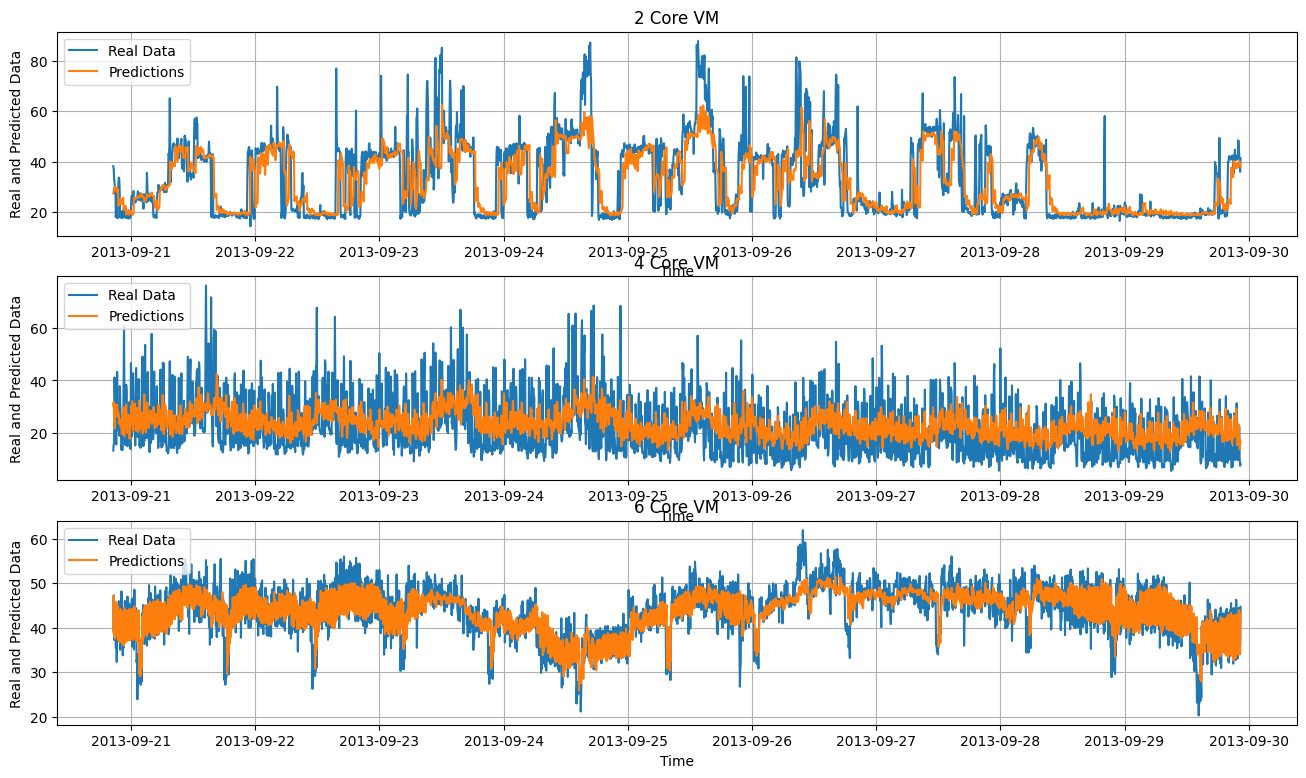

In [19]:
fig, (ax1, ax2,ax3) = plt.subplots(ncols=1, nrows=3, figsize=(16,9))

ax1.plot(post_df2.index[00:], post_df2['cpu_real'][00:], label='Real Data')
ax1.plot(post_df2.index[00:], post_df2['XBGR_pred'][00:], label='Predictions')
ax1.set_xlabel('Time')
ax1.set_ylabel('Real and Predicted Data')
#ax1.set_ylim([0,100])
ax1.grid()
ax1.set_title('2 Core VM')
ax1.legend(loc='upper left')

ax2.plot(post_df4.index[00:], post_df4['cpu_real'][00:], label='Real Data')
ax2.plot(post_df4.index[00:], post_df4['XBGR_pred'][00:], label='Predictions')
ax2.set_xlabel('Time')
ax2.set_ylabel('Real and Predicted Data')
ax2.grid()
#ax2.set_ylim([0,100])
ax2.set_title('4 Core VM')
ax2.legend(loc='upper left')

ax3.plot(post_df6.index[00:], post_df6['cpu_real'][00:], label='Real Data')
ax3.plot(post_df6.index[00:], post_df6['XBGR_pred'][00:], label='Predictions')
ax3.set_xlabel('Time')
ax3.set_ylabel('Real and Predicted Data')
ax3.grid()
#ax3.set_ylim([0,100])
ax3.set_title('6 Core VM')
ax3.legend(loc='upper left')

In [20]:
df_combined = pd.concat([post_df2, post_df4, post_df6])
df_combined.sort_index(inplace=True)
df_combined.head(10)

,XBGR_pred,cpu_real
DateTime,,
2013-09-20 20:35:00,27.273258,38.133333
2013-09-20 20:35:00,30.463655,13.133333
2013-09-20 20:35:00,39.009251,39.522222
2013-09-20 20:40:00,28.419765,36.766667
2013-09-20 20:40:00,31.810827,15.716667
2013-09-20 20:40:00,47.117130,47.288889
2013-09-20 20:45:00,29.268618,33.133333
2013-09-20 20:45:00,26.759064,16.100000
2013-09-20 20:45:00,38.076275,37.311111


In [21]:
def calculate_rmse(predictions, actuals):
    rmse = np.sqrt(mean_squared_error(actuals, predictions))
    return rmse

rmse = calculate_rmse(df_combined['XBGR_pred'], df_combined['cpu_real'])
rmse

8.855337674366822

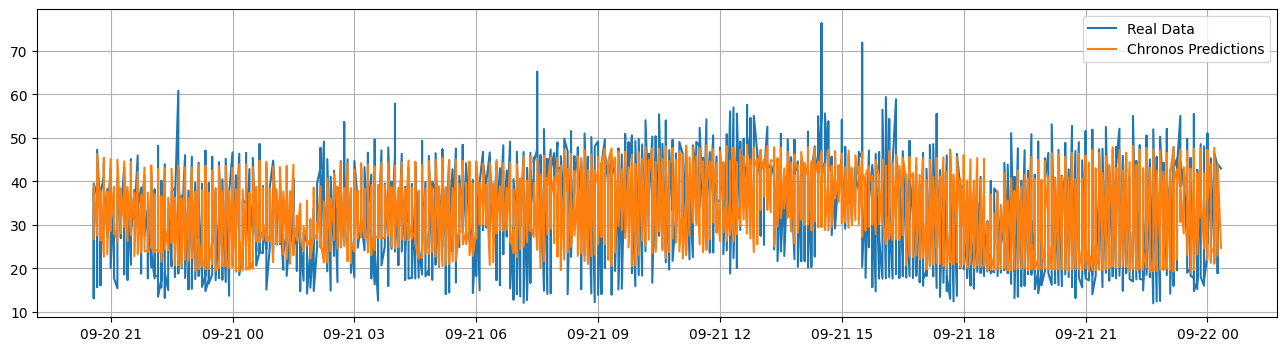

In [36]:
plt.figure(figsize=(16,4))
plt.plot(df_combined.index[:1000], df_combined['cpu_real'][:1000], label='Real Data')
plt.plot(df_combined.index[:1000], df_combined['XBGR_pred'][:1000], label='Chronos Predictions')
plt.grid()
plt.legend()
plt.show()

## Parallel Approach

In [22]:
def reassemble_datetime(df, df_norm, core):
    result = df_norm.copy()
    features = ['month', 'day', 'hour', 'minute']
    for feature_name in features:
        max_value = df[feature_name].max()
        min_value = df[feature_name].min()
        result[feature_name] = df_norm[feature_name] * (max_value - min_value) + min_value

    result['year'] = 2013
    result['Core'] = core
    result['DateTime'] = pd.to_datetime(result[['year', 'month', 'day', 'hour', 'minute']])
    result = result[['DateTime', 'Core']]
    return result

def denormalize(predictions, actuals, c_max, c_min, shape):
    denorm_predictions = predictions * (c_max - c_min) + c_min
    denorm_actuals = actuals * (c_max - c_min) + c_min
    denorm_predictions, denorm_actuals = denorm_predictions.reshape(predictions.shape[1], 1), denorm_actuals.reshape(actuals.shape[0] ,1)
    return denorm_predictions[:shape], denorm_actuals[:shape]

def plot_predictions(model, X, y, df, core):

    c_max = df['y'].max()
    c_min = df['y'].min()    

    row = X.iloc[0]
    row_reshape = row.values.reshape(1, -1)
    pred = model.predict(row_reshape)

    datetime_df = reassemble_datetime(df, X, core)
    
    denorm_pred, denorm_actual = denormalize(pred, y, c_max, c_min, datetime_df.shape[0])
    datetime_df['XBGR_pred'] = denorm_pred
    datetime_df['cpu_real'] = denorm_actual

    # post_process_dfs = pd.concat(post_process_dfs)
    # post_process_dfs.set_index('DateTime', inplace=True)
    # post_process_dfs.sort_index(inplace=True)
    return datetime_df

# assuming all the X_test has same number of rows at the moment 
horizon = 6
y2_np = y2_test.to_numpy()
y4_np = y4_test.to_numpy()
y6_np = y6_test.to_numpy()
post_list = []
for i in range(0, X2_test.shape[0], horizon):
    print(i)
    post_df2 = plot_predictions(model2, X2_test[i:i+horizon], y2_np[i], df2, core=2)
    post_df4 = plot_predictions(model4, X4_test.iloc[i:i+horizon], y4_np[i], df4, core=4)
    post_df6 = plot_predictions(model6, X6_test.iloc[i:i+horizon], y6_np[i], df6, core=6)

    tmp_df = pd.concat([post_df2, post_df4, post_df6])
    post_list.append(tmp_df)

post_df = pd.concat(post_list)

0
6
12
18
24
30
36
42
48
54
60
66
72
78
84
90
96
102
108
114
120
126
132
138
144
150
156
162
168
174
180
186
192
198
204
210
216
222
228
234
240
246
252
258
264
270
276
282
288
294
300
306
312
318
324
330
336
342
348
354
360
366
372
378
384
390
396
402
408
414
420
426
432
438
444
450
456
462
468
474
480
486
492
498
504
510
516
522
528
534
540
546
552
558
564
570
576
582
588
594
600
606
612
618
624
630
636
642
648
654
660
666
672
678
684
690
696
702
708
714
720
726
732
738
744
750
756
762
768
774
780
786
792
798
804
810
816
822
828
834
840
846
852
858
864
870
876
882
888
894
900
906
912
918
924
930
936
942
948
954
960
966
972
978
984
990
996
1002
1008
1014
1020
1026
1032
1038
1044
1050
1056
1062
1068
1074
1080
1086
1092
1098
1104
1110
1116
1122
1128
1134
1140
1146
1152
1158
1164
1170
1176
1182
1188
1194
1200
1206
1212
1218
1224
1230
1236
1242
1248
1254
1260
1266
1272
1278
1284
1290
1296
1302
1308
1314
1320
1326
1332
1338
1344
1350
1356
1362
1368
1374
1380
1386
1392
1398
1404
1410
1416
1

In [37]:
post_df[post_df['Core']==2].tail(12)

,Core,XBGR_pred,cpu_real
DateTime,,,
2013-09-29 21:30:00,2,37.345734,42.400000
2013-09-29 21:35:00,2,38.866173,40.800000
2013-09-29 21:40:00,2,39.322823,41.866667
2013-09-29 21:45:00,2,37.464905,41.000000
2013-09-29 21:50:00,2,38.931580,41.533333
2013-09-29 21:55:00,2,37.778862,42.200000
2013-09-29 22:00:00,2,38.873032,48.433333
2013-09-29 22:05:00,2,40.254181,44.466667
2013-09-29 22:10:00,2,40.259163,42.766667


In [23]:
post_df =  post_df.sort_values(by=['DateTime', 'Core'])
post_df.set_index('DateTime', inplace=True)

In [24]:
calculate_rmse(post_df['XBGR_pred'], post_df['cpu_real'])

8.855337674366822

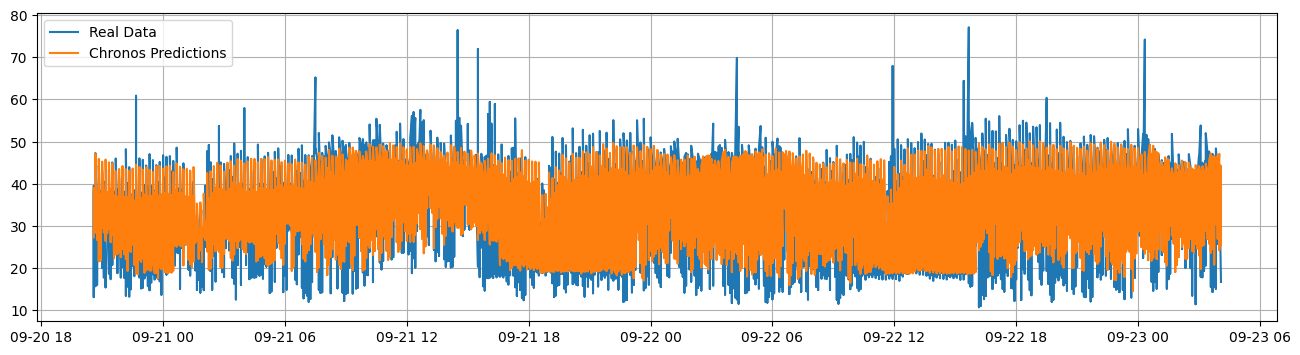

In [25]:
plt.figure(figsize=(16,4))
plt.plot(post_df.index[:2000], post_df['cpu_real'][:2000], label='Real Data')
plt.plot(post_df.index[:2000], post_df['XBGR_pred'][:2000], label='Chronos Predictions')
plt.grid()
plt.legend()
plt.show()

In [38]:
post_df.tail(20)

,Core,XBGR_pred,cpu_real
DateTime,,,
2013-09-29 21:55:00,4,17.551380,9.533333
2013-09-29 21:55:00,6,42.374069,44.222222
2013-09-29 22:00:00,2,38.873032,48.433333
2013-09-29 22:00:00,4,23.303669,14.650000
2013-09-29 22:00:00,6,33.945885,35.322222
2013-09-29 22:05:00,2,40.254181,44.466667
2013-09-29 22:05:00,4,21.353979,15.933333
2013-09-29 22:05:00,6,44.016426,44.511111
2013-09-29 22:10:00,2,40.259163,42.766667
